### **GAN**

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
latent_dim = 100
img_shape = (32, 32, 3)
save_interval = 2000  # Save plots every N iterations
output_dir = "gan_training"
os.makedirs(output_dir, exist_ok=True)

In [ ]:
def build_generator():
    inputs = keras.Input(shape=(latent_dim,))

    x = layers.Dense(8*8*256, use_bias=False)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(negative_slope=0.2)(x)

    x = layers.Reshape((8, 8, 256))(x)

    x = layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(negative_slope=0.2)(x)

    x = layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(negative_slope=0.2)(x)

    outputs = layers.Conv2DTranspose(3, kernel_size=3, strides=1, padding="same", activation="tanh")(x)

    return keras.Model(inputs, outputs, name="generator")

In [ ]:
def build_discriminator():
    inputs = keras.Input(shape=img_shape)

    x = layers.Conv2D(64, kernel_size=3, strides=2, padding="same")(inputs)
    x = layers.LeakyReLU(negative_slope=0.2)(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Conv2D(128, kernel_size=3, strides=2, padding="same")(x)
    x = layers.LeakyReLU(negative_slope=0.2)(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Flatten()(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)

    return keras.Model(inputs, outputs, name="discriminator")


In [ ]:
import tensorflow as tf

(x_train, _), (_, _) = keras.datasets.cifar10.load_data()
x_train = (x_train.astype("float32") - 127.5) / 127.5  # Normalize to [-1, 1]

batch_size = 128
dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(60000).batch(batch_size)

In [ ]:
generator = build_generator()
discriminator = build_discriminator()

cross_entropy = keras.losses.BinaryCrossentropy(from_logits=False)

generator_optimizer = keras.optimizers.Adam(1e-4)
discriminator_optimizer = keras.optimizers.Adam(1e-4)

In [ ]:
@tf.function
def train_step(images):
    noise = tf.random.normal([batch_size, latent_dim])

    # Train Discriminator
    with tf.GradientTape() as disc_tape, tf.GradientTape() as gen_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        disc_loss_real = cross_entropy(tf.ones_like(real_output), real_output)
        disc_loss_fake = cross_entropy(tf.zeros_like(fake_output), fake_output)
        disc_loss = disc_loss_real + disc_loss_fake

        gen_loss = cross_entropy(tf.ones_like(fake_output), fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

In [ ]:

def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    predictions = (predictions + 1) / 2.0  # Rescale to [0,1]

    fig = plt.figure(figsize=(4,4))
    for i in range(16):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i])
        plt.axis("off")
    plt.savefig(os.path.join(output_dir, f"image_at_epoch_{epoch}.png"))
    plt.close()

In [ ]:
def train(dataset, epochs):
    seed = tf.random.normal([16, latent_dim])  # Fixed seed for progress images

    for epoch in range(1, epochs+1):
        for image_batch in dataset:
            g_loss, d_loss = train_step(image_batch)

        if epoch % (save_interval // (len(x_train)//batch_size)) == 0:
            print(f"Epoch {epoch}, Gen Loss: {g_loss.numpy()}, Disc Loss: {d_loss.numpy()}")
            generate_and_save_images(generator, epoch, seed)

In [ ]:
train(dataset, epochs=50000 // (len(x_train)//batch_size))

Epoch 5, Gen Loss: 1.1570985317230225, Disc Loss: 0.9384942054748535
Epoch 10, Gen Loss: 0.8465421795845032, Disc Loss: 1.0192627906799316
Epoch 15, Gen Loss: 0.7267230749130249, Disc Loss: 1.447047472000122
Epoch 20, Gen Loss: 0.7438039779663086, Disc Loss: 1.334213376045227
Epoch 25, Gen Loss: 0.6656217575073242, Disc Loss: 1.5301166772842407
Epoch 30, Gen Loss: 0.6746082901954651, Disc Loss: 1.4111839532852173
Epoch 35, Gen Loss: 0.7226025462150574, Disc Loss: 1.3679320812225342
Epoch 40, Gen Loss: 1.234715223312378, Disc Loss: 1.1158130168914795
Epoch 45, Gen Loss: 0.848253607749939, Disc Loss: 1.2295618057250977
Epoch 50, Gen Loss: 0.7357770800590515, Disc Loss: 1.512691617012024
Epoch 55, Gen Loss: 0.7489485740661621, Disc Loss: 1.429765224456787
Epoch 60, Gen Loss: 0.8489645719528198, Disc Loss: 1.1015965938568115
Epoch 65, Gen Loss: 1.0640161037445068, Disc Loss: 0.9500246047973633
Epoch 70, Gen Loss: 0.7002219557762146, Disc Loss: 1.8414229154586792
Epoch 75, Gen Loss: 0.75943

In [ ]:
def generate_random_image():
    noise = tf.random.normal([1, latent_dim])
    prediction = generator(noise, training=False)
    img = (prediction[0].numpy() + 1) / 2.0
    plt.figure(figsize=(1, 1))
    plt.imshow(img)
    plt.axis("off")
    plt.show()

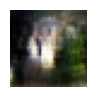

In [ ]:
# generating images

generate_random_image()